## Modelling the sea using grid-based methods

In [1]:
!pip install basemap
!pip install basemap-data-hires

!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib
!pip install graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /tmp/jupyterlab-debug-xb791nid.log
An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https

In [1]:
from pygradu import gridify
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from datetime import datetime
from datetime import timedelta
import time
import copy

import math
import IPython

In [2]:
base_lat = [32, 36]
base_lon = [125, 129]

# 탱커와 벌커의 평균 속도: 15~16노트(28~30km/h)
avg_speed = 25
pivot_time = 5
gridmap_pivot_distance_km = 5

earth_radius = 6371
lat_distance_per_one = round(earth_radius * math.pi / 180, 3)
lon_distance_per_one = {0:111.322, 5:110.902, 10:109.643, 15:117.553, 20:114.650, 25:100.953, 30:96.490, 
                        35:91.290, 40:85.397, 45:78.850, 50:71.700, 55:63.997, 60:55.803, 65:47.178, 70:38.188, 
                        75:28.904, 80:19.394, 85:9.735, 90:0}

absolute_distance_pos = [[0],[0]]

for lat in range(base_lat[0]+1, base_lat[1]+1):
    absolute_distance_pos[0].append(lat_distance_per_one)
    absolute_distance_pos[1].append(lon_distance_per_one[(lat//5)*5])

In [3]:
absolute_distance_pos

[[0, 111.195, 111.195, 111.195, 111.195], [0, 96.49, 96.49, 91.29, 91.29]]

In [4]:
grid_lat = [base_lat[0]]
grid_lon = [base_lon[0]]

for ilat in range(1, len(absolute_distance_pos[0])):
    vlat = lat_distance_per_one # this is never changed. so not need
    while(True):
        tlat = 0
        if(tlat != gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km - tlat
        elif(vlat > gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km
        else: tlat = vlat # vlat <= gridmap_pivot_distance_km

        vlat -= tlat
        dlat = tlat/lat_distance_per_one

        grid_lat.append(grid_lat[-1] + dlat)

        if(vlat <= 0):
            break

collection_grid_lat = [(grid_lat[i]-base_lat[0])*(base_lat[1]-grid_lat[-1])/(grid_lat[-1]-base_lat[0]) for i in range(0, len(grid_lat))]
grid_lat = [x+y for x,y in zip(grid_lat, collection_grid_lat)]

for ilon in range(1, len(absolute_distance_pos[1])):
    vlon = absolute_distance_pos[1][ilon]
    while(True):
        tlon = 0
        if(tlon != gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km - tlon
        elif(vlon > gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km
        else: tlon = vlon # vlon <= gridmap_pivot_distance_km
            
        vlon -= tlon
        dlon = tlon/lon_distance_per_one[(ilon//5)*5]
            
        grid_lon.append(grid_lon[-1] + dlon)
            
        if(vlon <= 0):
            break

collection_grid_lon = [(grid_lon[i]-base_lon[0])*(base_lon[1]-grid_lon[-1])/(grid_lon[-1]-base_lon[0]) for i in range(0, len(grid_lon))]
grid_lon = [x+y for x,y in zip(grid_lon, collection_grid_lon)]
        
print('Grid_latitude len: %d'%(len(grid_lat)))
print('Grid_longitude len: %d'%(len(grid_lon)))

Grid_latitude len: 93
Grid_longitude len: 79


In [5]:
def draw_basemap_grid(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x, y)
    poly = Polygon(list(xy), facecolor="none", edgecolor='black', lw=0.7, alpha=0.4)
    plt.gca().add_patch(poly)
    return poly

In [6]:
DATA_DIR = "data/AIS/"
AIS_FILE_DIR = 'Dynamic_20200204.csv' 
skiprow_count = 3

f = open(DATA_DIR+AIS_FILE_DIR, 'r', encoding='cp949')
for i in range(0, skiprow_count):
    line = f.readline()
    if not line: break
    print(line)
f.close()

ais = pd.read_csv(DATA_DIR+AIS_FILE_DIR,
                  encoding='cp949', sep='\s+|,', engine='python', 
                  skiprows=range(0, skiprow_count),
                  names=['MMSI','일자', '시간', '위도','경도', 'SOG', 'COG', 'Heading'])
print('Data len in AIS:' + str(len(ais)))
ais.drop(ais[(ais['위도'] < base_lat[0]) | (ais['위도'] > base_lat[1]) | (ais['경도'] < base_lon[0]) | (ais['경도'] > base_lon[1])].index, inplace=True)
print('Data len in Range:' + str(len(ais)))

조회 기간 : 2020-02-04 00:00:00 ~ 2020-02-04 23:59:59

조회선박 척수 : 7850

MMSI,일시,위도,경도,SOG,COG,Heading

Data len in AIS:20653646
Data len in Range:11078235


In [7]:
ais.dtypes

MMSI        object
일자          object
시간          object
위도         float64
경도         float64
SOG        float64
COG        float64
Heading      int64
dtype: object

In [8]:
ais

MMSI          일자        시간         위도  \
1         rjFyyVyimurB7BM2WdKWWQ==  2020-02-04  00:00:01  33.952555   
2         rjFyyVyimurB7BM2WdKWWQ==  2020-02-04  00:00:12  33.952547   
3         rjFyyVyimurB7BM2WdKWWQ==  2020-02-04  00:00:22  33.952538   
4         rjFyyVyimurB7BM2WdKWWQ==  2020-02-04  00:00:33  33.952530   
5         rjFyyVyimurB7BM2WdKWWQ==  2020-02-04  00:00:42  33.952528   
...                            ...         ...       ...        ...   
20652629  f6trMpkAwYR37AuCx/LNbw==  2020-02-04  18:54:18  35.068217   
20653100  f6trMpkAwYR37AuCx/LNbw==  2020-02-04  21:06:47  35.068207   
20653279  f6trMpkAwYR37AuCx/LNbw==  2020-02-04  22:01:49  35.068263   
20653393  f6trMpkAwYR37AuCx/LNbw==  2020-02-04  22:35:05  35.068268   
20653594  f6trMpkAwYR37AuCx/LNbw==  2020-02-04  23:41:33  35.068315   

                  경도  SOG    COG  Heading  
1         126.817868  3.0   96.4       90  
2         126.818030  2.9   92.6       89  
3         126.818197  2.8   89.8       88  
4         126.818360  2.9   89.7       88  
5         126.818527  2.8   95.1       88  
...              ...  ...    ...      ...  
20652629  128.789568  0.0  293.8      511  
20653100  128.789572  0.0  191.2      511  
20653279  128.789555  0.2  217.9      511  
20653393  128.789590  0.0  340.5      511  
20653594  128.789582  0.0  134.1      511  

[11078235 rows x 8 columns]

Draw Basemap
Draw Gridmap
Draw AIS data


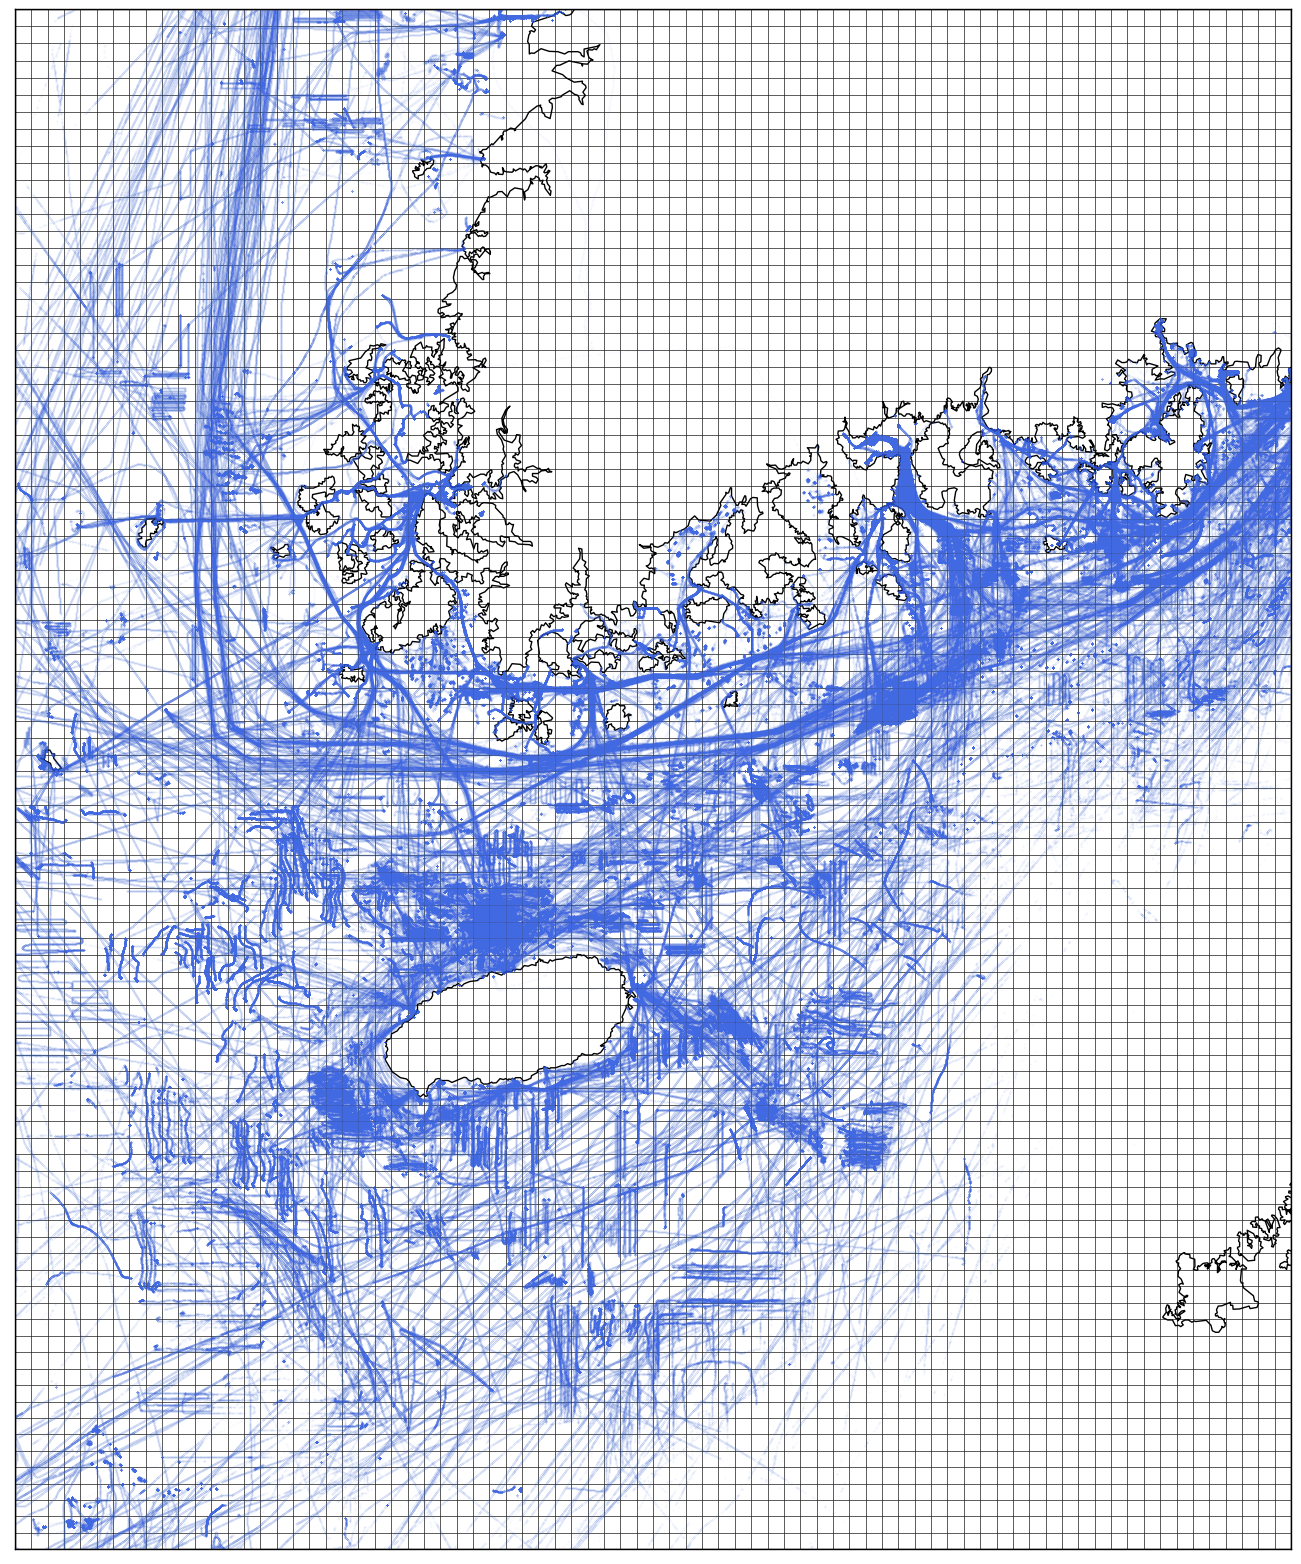

In [9]:
print('Draw Basemap')
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

print('Draw Gridmap')
grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m)
        key = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon-1])
        grid_map[key] = p

print('Draw AIS data')
ais_lons = ais.경도.tolist()
ais_lats = ais.위도.tolist()

ais_lons, ais_lats = m(ais_lons, ais_lats)
plt.plot(ais_lons, ais_lats, 'o', c='royalblue', alpha=0.1, markersize=0.2)
plt.show()

In [10]:
mmsis = list(set(ais["MMSI"].tolist()))
ais_dict = {}
progress = []
for i in range(0, len(mmsis)):
    per = int((i/len(mmsis))*100)
    if(per%5 == 0 and per not in progress):
        progress.append(per)
        print('Progress rate: %d/%d'%(per, 100))
        
    ais_dict[mmsis[i]] = ais[ais['MMSI'] == mmsis[i]]
print('Progress rate: %d/%d'%(100, 100))

Progress rate: 0/100
Progress rate: 5/100
Progress rate: 10/100
Progress rate: 15/100
Progress rate: 20/100
Progress rate: 25/100
Progress rate: 30/100
Progress rate: 35/100
Progress rate: 40/100
Progress rate: 45/100
Progress rate: 50/100
Progress rate: 55/100
Progress rate: 60/100
Progress rate: 65/100
Progress rate: 70/100
Progress rate: 75/100
Progress rate: 80/100
Progress rate: 85/100
Progress rate: 90/100
Progress rate: 95/100
Progress rate: 100/100


In [11]:
current_time = '2020-02-04 12:00:00'
predict_time = 1
selected_grid = [[34.5, 128.05]]

In [12]:
# detect ship
current_vessel_position = {}
date_time_current = time.strptime(current_time, '%Y-%m-%d %H:%M:%S')
for mmsi in mmsis:
    for row, ser in ais_dict[mmsi].iterrows():
        mdate = ser['일자']
        mtime = ser['시간']
        datetime_str_obj = "%s %s"%(mdate, mtime)
        date_time_obj = time.strptime(datetime_str_obj, '%Y-%m-%d %H:%M:%S')
        
        if(date_time_current <= date_time_obj):
            current_vessel_position[mmsi] = ser
            break

In [13]:
print('current_vessel_position len: %d'%len(current_vessel_position))
print('ais_dict len: %d'%len(ais_dict))
print('mmsis len: %d'%len(mmsis))

current_vessel_position len: 4090
ais_dict len: 4707
mmsis len: 4707


In [14]:
def find_grid_key(llist, v):
    result = -1
    for i in range(0, len(llist)-1):
        if llist[i] <= v and llist[i+1] >= v:
            return llist[i]
    return result

In [15]:
def find_detect_grid(grid_map, grid_lat, grid_lon, klat, klon, selected_grid):
    ilat = grid_lat.index(klat)
    ilon = grid_lon.index(klon)
    vlat = grid_lat[ilat]
    vlon = grid_lon[ilon]
    key = '(%f,%f)'%(vlat, vlon)
    
    next_detect_grid = []
    try:
        if(grid_map[key][2] == 'selected'):
            if(ilat > 0):
                tkey = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon])
                if(grid_map[tkey][2] != 'selected' and grid_map[tkey][2] != 'detected'):
                    next_detect_grid.append([grid_lat[ilat-1], grid_lon[ilon]])
            if(ilat < len(grid_lat) -1):
                tkey = '(%f,%f)'%(grid_lat[ilat+1], grid_lon[ilon])
                if(grid_map[tkey][2] != 'selected' and grid_map[tkey][2] != 'detected'):
                    next_detect_grid.append([grid_lat[ilat+1], grid_lon[ilon]])
            if(ilon > 0):
                tkey = '(%f,%f)'%(grid_lat[ilat], grid_lon[ilon-1])
                if(grid_map[tkey][2] != 'selected' and grid_map[tkey][2] != 'detected'):
                    next_detect_grid.append([grid_lat[ilat], grid_lon[ilon-1]])
            if(ilon < len(grid_lat) -1):
                tkey = '(%f,%f)'%(grid_lat[ilat], grid_lon[ilon+1])
                if(grid_map[tkey][2] != 'selected' and grid_map[tkey][2] != 'detected'):
                    next_detect_grid.append([grid_lat[ilat], grid_lon[ilon+1]])

            return grid_map[key], next_detect_grid
        elif(grid_map[key][2] == 'detected'):
            return None, next_detect_grid
    except:
        return None, next_detect_grid
    
    flag = False
    for grid in selected_grid:
        square_distance = (lat_distance_per_one*abs(grid[0]-vlat))**2 + (lon_distance_per_one[(vlat//5)*5]*abs(grid[1]-vlon))**2
        if(square_distance <= (avg_speed*predict_time)**2):
            flag = True
            break
    
    try:
        if(flag):
            grid_map[key][2] = 'detected'
            grid_map[key][0].set(facecolor='blue', alpha=0.3)

            if(ilat > 0):
                tkey = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon])
                if(grid_map[tkey][2] != 'selected' and grid_map[tkey][2] != 'detected'):
                    next_detect_grid.append([grid_lat[ilat-1], grid_lon[ilon]])
            if(ilat < len(grid_lat) - 1):
                tkey = '(%f,%f)'%(grid_lat[ilat+1], grid_lon[ilon])
                if(grid_map[tkey][2] != 'selected' and grid_map[tkey][2] != 'detected'):
                    next_detect_grid.append([grid_lat[ilat+1], grid_lon[ilon]])
            if(ilon > 0):
                tkey = '(%f,%f)'%(grid_lat[ilat], grid_lon[ilon-1])
                if(grid_map[tkey][2] != 'selected' and grid_map[tkey][2] != 'detected'):
                    next_detect_grid.append([grid_lat[ilat], grid_lon[ilon-1]])
            if(ilon < len(grid_lat) - 1):
                tkey = '(%f,%f)'%(grid_lat[ilat], grid_lon[ilon+1])
                if(grid_map[tkey][2] != 'selected' and grid_map[tkey][2] != 'detected'):
                    next_detect_grid.append([grid_lat[ilat], grid_lon[ilon+1]])
            return grid_map[key], next_detect_grid
        return None, next_detect_grid
    except:
        return None, next_detect_grid

In [16]:
# def find_detect_grid(grid_queue, grid_map, grid_lat, grid_lon, klat, klon, slat, slon):
#     ilat = grid_lat.index(klat)
#     ilon = grid_lon.index(klon)
#     if(ilat > 0):
#         vlat = grid_lat[ilat-1]
#         vlon = grid_lon[ilon]
#         key = '(%f,%f)'%(vlat, vlon)
#         square_distance = (lat_distance_per_one*abs(slat-vlat))**2 + (lon_distance_per_one[(vlat//5)*5]*abs(slon-vlon))**2
#         if(square_distance <= (avg_speed*predict_time)**2):
#             if(grid_map[key][2] != 'selected' and grid_map[key][2] != 'detected'):
#                 grid_map[key][2] = 'detected'
#                 grid_map[key][0].set(facecolor='blue', alpha=0.3)
#                 grid_queue.append(grid_map[key])
#             find_detect_grid(grid_queue, grid_map, grid_lat, grid_lon, vlat, vlon, slat, slon)
            
#     if(ilat < len(grid_lat)-1):
#         vlat = grid_lat[ilat+1]
#         vlon = grid_lon[ilon]
#         key = '(%f,%f)'%(vlat, vlon)
#         square_distance = (lat_distance_per_one*abs(slat-vlat))**2 + (lon_distance_per_one[(vlat//5)*5]*abs(slon-vlon))**2
#         if(square_distance <= (avg_speed*predict_time)**2):
#             if(grid_map[key][2] != 'selected' and grid_map[key][2] != 'detected'):
#                 grid_map[key][2] = 'detected'
#                 grid_map[key][0].set(facecolor='blue', alpha=0.3)
#                 grid_queue.append(grid_map[key])
#             find_detect_grid(grid_queue, grid_map, grid_lat, grid_lon, vlat, vlon, slat, slon)
        
#     if(ilon > 0):
#         vlat = grid_lat[ilat]
#         vlon = grid_lon[ilon-1]
#         key = '(%f,%f)'%(vlat, vlon)
#         square_distance = (lat_distance_per_one*abs(slat-vlat))**2 + (lon_distance_per_one[(vlat//5)*5]*abs(slon-vlon))**2
#         if(square_distance <= (avg_speed*predict_time)**2):
#             if(grid_map[key][2] != 'selected' and grid_map[key][2] != 'detected'):
#                 grid_map[key][2] = 'detected'
#                 grid_map[key][0].set(facecolor='blue', alpha=0.3)
#                 grid_queue.append(grid_map[key])
#             find_detect_grid(grid_queue, grid_map, grid_lat, grid_lon, vlat, vlon, slat, slon)
        
#     if(ilon < len(grid_lon)-1):
#         vlat = grid_lat[ilat]
#         vlon = grid_lon[ilon+1]
#         key = '(%f,%f)'%(vlat, vlon)
#         square_distance = (lat_distance_per_one*abs(slat-vlat))**2 + (lon_distance_per_one[(vlat//5)*5]*abs(slon-vlon))**2
#         if(square_distance <= (avg_speed*predict_time)**2):
#             if(grid_map[key][2] != 'selected' and grid_map[key][2] != 'detected'):
#                 grid_map[key][2] = 'detected'
#                 grid_map[key][0].set(facecolor='blue', alpha=0.3)
#                 grid_queue.append(grid_map[key])
#             find_detect_grid(grid_queue, grid_map, grid_lat, grid_lon, vlat, vlon, slat, slon)
    

Draw Basemap
Draw Gridmap
Draw Ships
Calculate grid congestion per each
Draw Graduation
Draw Selected Grid
Draw Detected Grid


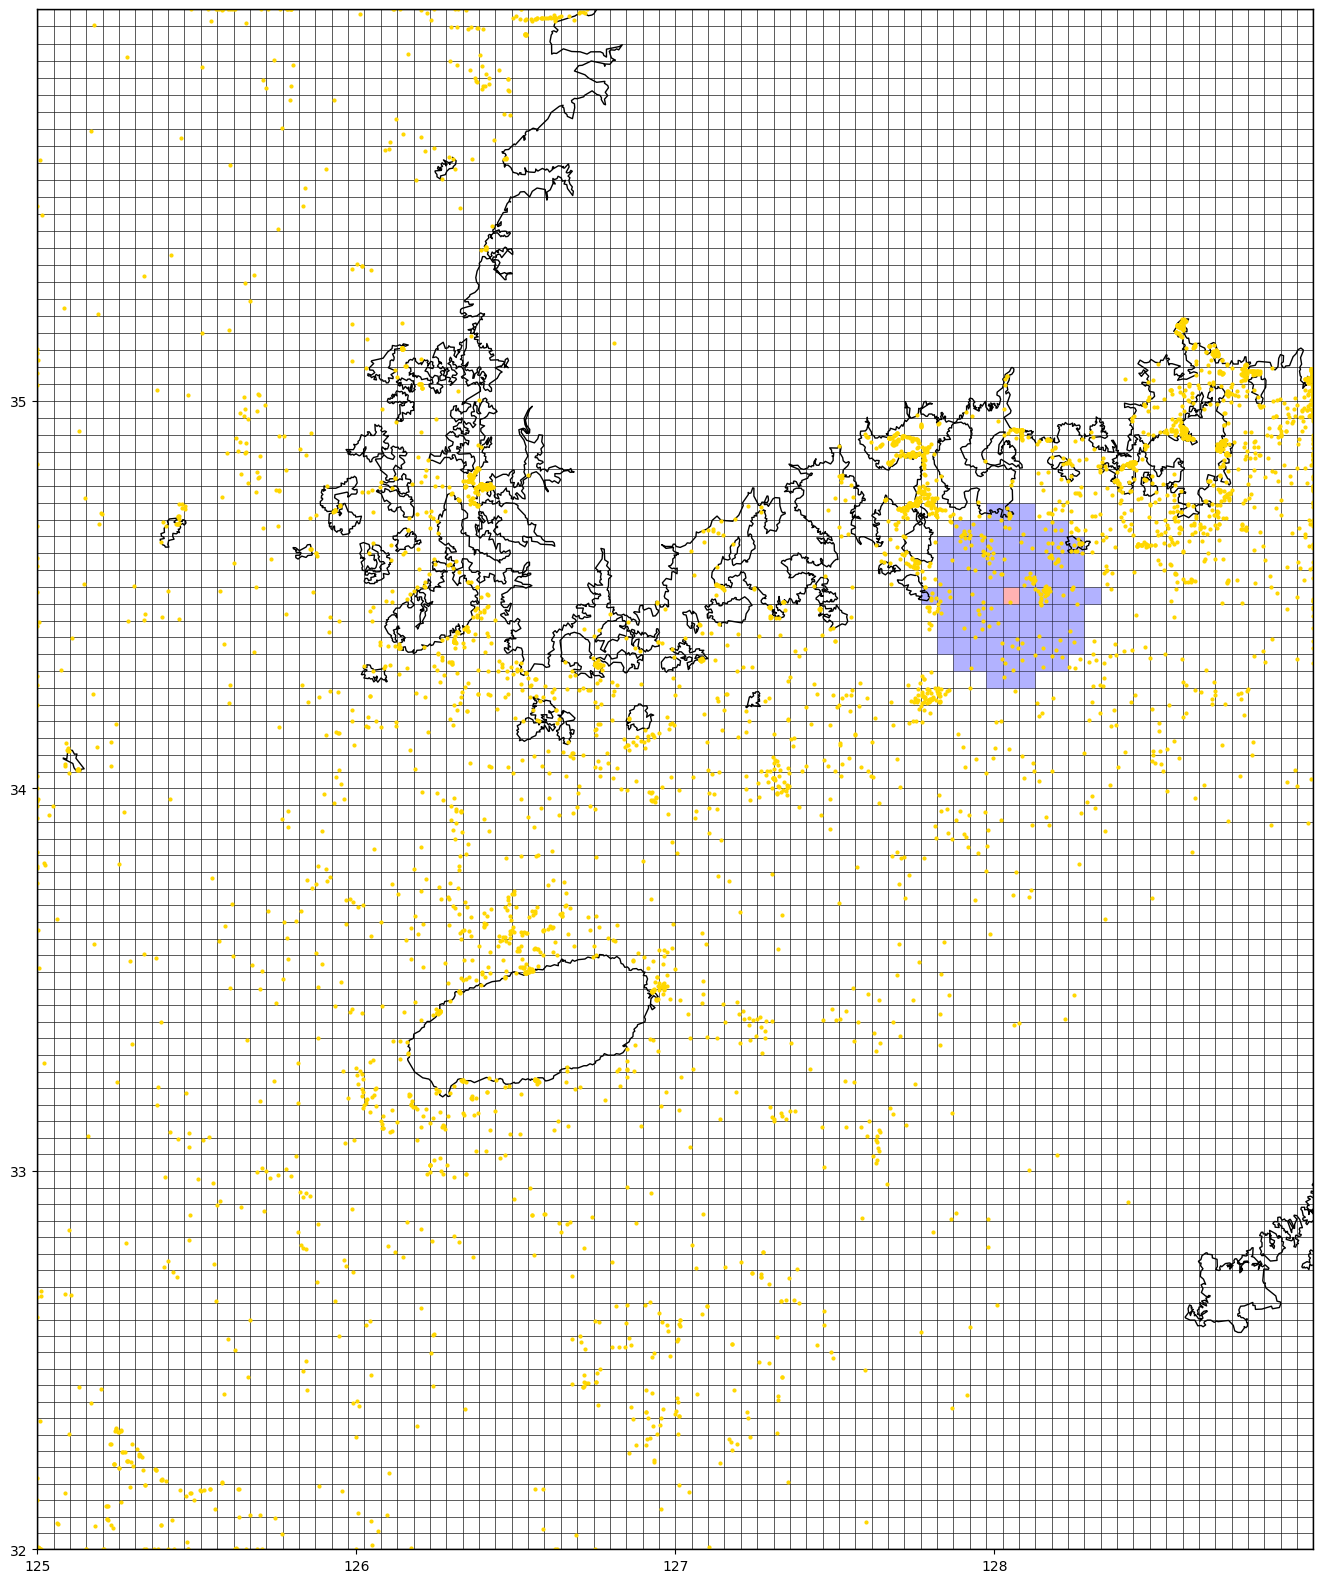

In [17]:
print('Draw Basemap')
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

print('Draw Gridmap')
grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m)
        key = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon-1])
        grid_map[key] = [p, [], '']

print('Draw Ships')
for mmsi in mmsis:
    if mmsi not in current_vessel_position:
        continue
    ser = current_vessel_position[mmsi]
    mlon, mlat = m(ser['경도'], ser['위도'])
    plt.plot(mlon, mlat, 'o', c='gold', alpha=1, markersize=2)
            

print('Calculate grid congestion per each')
# 전체 기간
# for lon in ais.경도.tolist():
#     klon = find_grid_key(grid_lon, lon)
#     for lat in ais.위도.tolist():
#         klat = find_grid_key(grid_lat, lat)
#         key = '(%f,%f)'%(klat, klon)
#         grid_map[key][1] += 1

for mmsi in mmsis:
    if mmsi not in current_vessel_position:
        continue
    ser = current_vessel_position[mmsi]
    klat = find_grid_key(grid_lat, ser['위도'])
    klon = find_grid_key(grid_lon, ser['경도'])
    key = '(%f,%f)'%(klat, klon)
    grid_map[key][1].append(mmsi)

print('Draw Graduation')
xt, yt = m(np.arange(base_lon[0], base_lon[1]), np.arange(base_lat[0], base_lat[1]))
plt.xticks(xt, labels = [str(x) for x in np.arange(base_lon[0], base_lon[1])])
plt.yticks(yt, labels = [str(x) for x in np.arange(base_lat[0], base_lat[1])])

print('Draw Selected Grid')
for pos in selected_grid:
    klat = find_grid_key(grid_lat, pos[0])
    klon = find_grid_key(grid_lon, pos[1])
    key = '(%f,%f)'%(klat, klon)
    grid_map[key][2] = 'selected'
    grid_map[key][0].set(facecolor='red', alpha=0.3)
    
print('Draw Detected Grid')
detected_grid = []
temp_queue = [[find_grid_key(grid_lat, x[0]), find_grid_key(grid_lon, x[1])] for x in copy.deepcopy(selected_grid)]
temp_grid = [[find_grid_key(grid_lat, x[0]), find_grid_key(grid_lon, x[1])] for x in copy.deepcopy(selected_grid)]
while(len(temp_queue) > 0):
    pos = temp_queue.pop(0)
    grid, new_queue = find_detect_grid(grid_map, grid_lat, grid_lon, pos[0], pos[1], temp_grid)
    
    if(grid is not None):
        temp_queue = temp_queue + new_queue
        detected_grid.append(grid)
    
# grid_queue = []
# for pos in selected_grid:
#     klat = find_grid_key(grid_lat, pos[0])
#     klon = find_grid_key(grid_lon, pos[1])
#     find_detect_grid(grid_queue, grid_map, grid_lat, grid_lon, klat, klon, klat, klon)
    
plt.show()

In [18]:
print('Detected Grid Count: %d'%len(detected_grid))
print('Ship Count in Detected/Selected Grid: %d'%sum([len(x[1]) for x in detected_grid]))

Detected Grid Count: 85
Ship Count in Detected/Selected Grid: 169



LSTM columns - 각 Grid에 대한 정보 (멀리있는 Grid부터 입력)
혼잡도(선박수), 평균 헤딩, 평균 SOG, 평균 COG -> 목표 지역 중앙으로부터 평균 COG의 각도

* Heading과 COG과 신뢰할 수 없음.
* 직접구함. 5분전 움직임으로?
* SOG는 Speed Of Ground로 신뢰할 수 있는 정보.
* Heading과 COG를 대체할 수단 필요 -> 벡터표현 -> 스칼라 값은 제외 -> 벡터로 각도를 계산할 것. -> 3분이 유효할 것으로 인식됨. -> 명확하지 않음. -> 항로와 Grid를 토대로 진행


- 오전 7시 ~ 12시
- 오후 12시 ~ 18시
- 오후 18시 ~ 24시
- 오전 24시 ~ 07시

-> 오후 12시 부터 오후 6시까지 정보 학습

In [19]:
# OOW52pEic5jqY9sI4MLb2g==

In [20]:
learning_start_pivot_time = '2020-02-04 12:00:00'
learning_end_pivot_time = '2020-02-04 18:00:00'

In [21]:
# detect ship
vessel_positions = []

start_pivot_datetime = datetime.strptime(learning_start_pivot_time, '%Y-%m-%d %H:%M:%S')
end_pivot_datetime = datetime.strptime(learning_end_pivot_time, '%Y-%m-%d %H:%M:%S')

for seq in range(0, int(end_pivot_datetime.hour) - int(start_pivot_datetime.hour) + 1):
    seq_positions = {}
    seq_datetime = datetime.strptime(learning_start_pivot_time, '%Y-%m-%d %H:%M:%S')
    seq_datetime = seq_datetime + timedelta(hours=seq)
    for mmsi in mmsis:
        for row, ser in ais_dict[mmsi].iterrows():
            mdata = ser['일자']
            mtime = ser['시간']
            datetime_str_obj = "%s %s"%(mdate, mtime)
            datetime_obj = datetime.strptime(datetime_str_obj, '%Y-%m-%d %H:%M:%S')
            
            if(seq_datetime <= datetime_obj):
                seq_positions[mmsi] = ser
                break
    vessel_positions.append(seq_positions)
    print('Launched success: ' + str(seq_datetime))
print('Launched all')

Launched success: 2020-02-04 12:00:00
Launched success: 2020-02-04 13:00:00
Launched success: 2020-02-04 14:00:00
Launched success: 2020-02-04 15:00:00
Launched success: 2020-02-04 16:00:00
Launched success: 2020-02-04 17:00:00
Launched success: 2020-02-04 18:00:00
Launched all


Draw Basemap
Draw Gridmap
Draw Ships
Draw Graduation


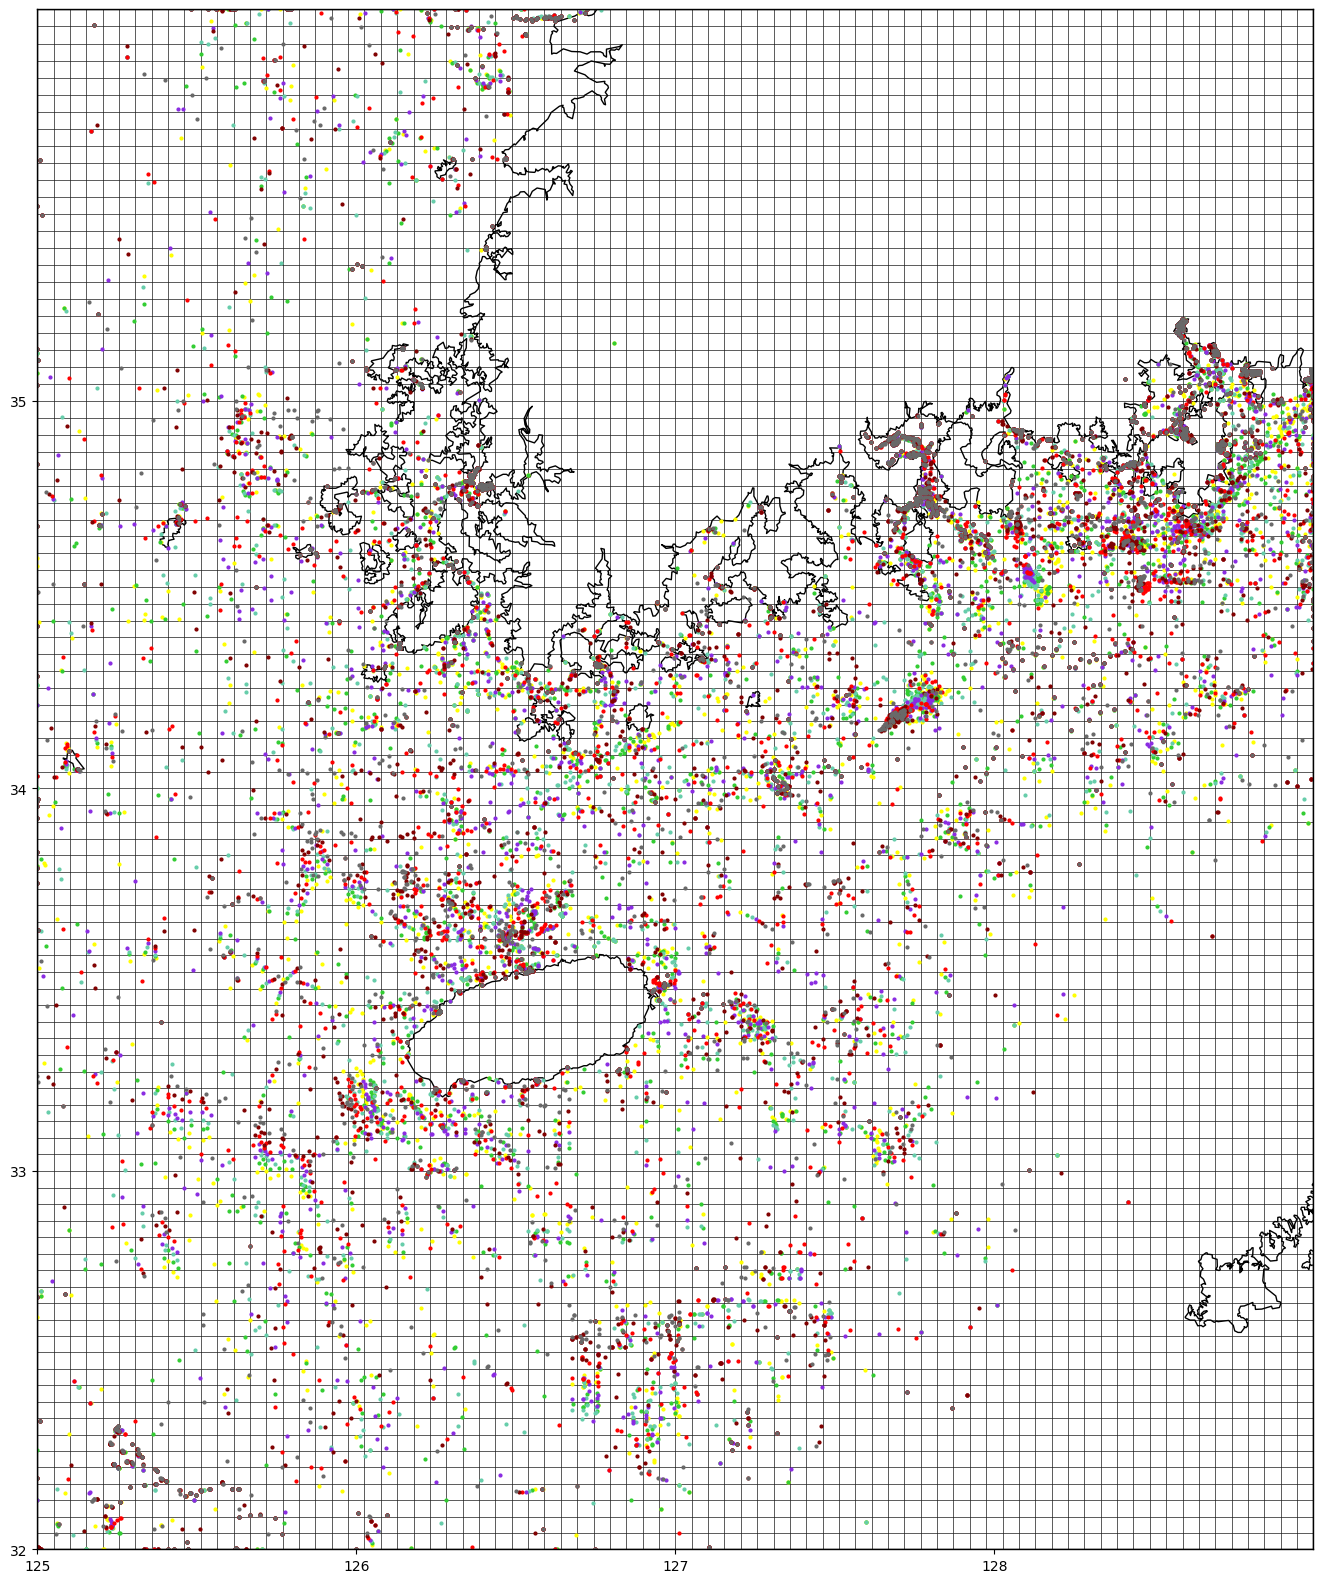

In [22]:
print('Draw Basemap')
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

print('Draw Gridmap')
grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m)
        key = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon-1])
        grid_map[key] = [p, [], '', grid_lat[ilat-1], grid_lon[ilon-1]]

print('Draw Ships')
time_color = ['yellow', 'limegreen', 'mediumaquamarine', 'blueviolet', 'red', 'maroon', 'dimgray', 'black']
for seq in range(0, len(vessel_positions)):
    for mmsi in mmsis:
        if mmsi not in vessel_positions[seq]:
            continue
        ser = vessel_positions[seq][mmsi]
        mlon, mlat = m(ser['경도'], ser['위도'])
        plt.plot(mlon, mlat, 'o', c=time_color[seq], alpha=1, markersize=2)            

print('Draw Graduation')
xt, yt = m(np.arange(base_lon[0], base_lon[1]), np.arange(base_lat[0], base_lat[1]))
plt.xticks(xt, labels = [str(x) for x in np.arange(base_lon[0], base_lon[1])])
plt.yticks(yt, labels = [str(x) for x in np.arange(base_lat[0], base_lat[1])])
    
plt.show()

In [26]:
# get gridmap_weight
WEIGHT_DIR_PATH = 'gridmap_weight/'
WEIGHT_FILE_PATH = 'WEIGHT_Dynamic_20200203_D%sLA0%sLA1%sLO0%sLO1%s.csv'%(str(gridmap_pivot_distance_km),
                                                                          str(base_lat[0]).replace('.','_'),
                                                                          str(base_lat[1]).replace('.','_'),
                                                                          str(base_lon[0]).replace('.','_'),
                                                                          str(base_lon[1]).replace('.','_'))

In [27]:
grid_weight = pd.read_csv(WEIGHT_DIR_PATH+WEIGHT_FILE_PATH)
grid_weight

key  north_weight  east_weight  south_weight  \
0     (32.000000,125.000000)             9            0             0   
1     (32.043478,125.000000)             3            0             0   
2     (32.086957,125.000000)             1            0             0   
3     (32.130435,125.000000)             1            0             0   
4     (32.173913,125.000000)             0            0             0   
...                      ...           ...          ...           ...   
7171  (35.782609,128.948718)             0            0             0   
7172  (35.826087,128.948718)             0            0             0   
7173  (35.869565,128.948718)             0            0             0   
7174  (35.913043,128.948718)             0            0             0   
7175  (35.956522,128.948718)             0            0             0   

      west_weight  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
7171            0  
7172            0  
7173            0  
7174            0  
7175            0  

[7176 rows x 5 columns]

In [28]:
#[[lat, lon]]
training_data = {'data_time': [],
          'predict_time': [],
          'detected_grid': [], # 멀리 있는 것 부터 : [{avg_sog, dir_weight, ship_count}]
          'true_value': []
         }

In [29]:
training_set_dir = 'training_data/'

In [30]:
start_pivot_datetime = datetime.strptime(learning_start_pivot_time, '%Y-%m-%d %H:%M:%S')
end_pivot_datetime = datetime.strptime(learning_end_pivot_time, '%Y-%m-%d %H:%M:%S')

original_grid_maps = []
for seq in range(0, int(end_pivot_datetime.hour) - int(start_pivot_datetime.hour) + 1):
    seq_datetime = datetime.strptime(learning_start_pivot_time, '%Y-%m-%d %H:%M:%S')
    seq_datetime = seq_datetime + timedelta(hours=seq)
    
    temp_grid_map = copy.deepcopy(grid_map)
    for mmsi in mmsis:
        if mmsi not in vessel_positions[seq]:
            continue
        ser = vessel_positions[seq][mmsi]
        klat = find_grid_key(grid_lat, ser['위도'])
        klon = find_grid_key(grid_lon, ser['경도'])
        key = '(%f,%f)'%(klat, klon)
        temp_grid_map[key][1].append(mmsi)
    original_grid_maps.append(temp_grid_map)

In [31]:
seq = 0
seq_datetime = datetime.strptime(learning_start_pivot_time, '%Y-%m-%d %H:%M:%S')
seq_datetime = seq_datetime + timedelta(hours=seq)
        
for ilon in range(0, len(grid_lon)-1):
    progress = []
    print('Launching state : sequence %d - %d/%d'%(seq, ilon, len(grid_lon)-1))
    for ilat in range(0, len(grid_lat)-1):
        temp_grid_map = copy.deepcopy(original_grid_maps[seq])
        detected_grid = []
            
        selected_lat = (grid_lat[ilat] + grid_lat[ilat+1])/2
        selected_lon = (grid_lon[ilon] + grid_lon[ilon+1])/2
        selected_key = '(%f,%f)'%(find_grid_key(grid_lat, selected_lat), find_grid_key(grid_lon, selected_lon))
        temp_grid_map[selected_key][2] = 'selected'
    
        temp_queue = [[find_grid_key(grid_lat, selected_lat), find_grid_key(grid_lon, selected_lon)]]
        temp_grid = [[find_grid_key(grid_lat, selected_lat), find_grid_key(grid_lon, selected_lon)]]
            
        while(len(temp_queue) > 0):
            pos = temp_queue.pop(0)
            # def find_detect_grid(grid_map, grid_lat, grid_lon, klat, klon, selected_grid)
            grid, new_queue = find_detect_grid(temp_grid_map, grid_lat[0:len(grid_lat)-1], grid_lon[0:len(grid_lon)-1], pos[0], pos[1], temp_grid)

            if(grid is not None):
                temp_queue = temp_queue + new_queue
                detected_grid.append(grid)
        detected_grid.reverse()
            
        training_data['data_time'].append(str(seq_datetime))
        training_data['predict_time'].append(str(seq_datetime + timedelta(hours=seq)))
        training_data['true_value'].append(len(original_grid_maps[seq+1][selected_key][1]))
            
        dg_list = []
        for grid in detected_grid:
            ship_count = len(grid[1])
                
            avg_sog = 0
            if(len(grid[1]) != 0):
                for mmsi in grid[1]:
                    avg_sog += vessel_positions[seq][mmsi]['SOG']
                avg_sog = avg_sog/len(grid[1])
            
            dir_weight = 0
            dglat = grid[3]
            dglon = grid[4]
            dgkey = '(%f,%f)'%(dglat, dglon)
            if(grid_lat[ilat] > dglat):
                dir_weight += int(grid_weight[grid_weight['key'] == dgkey]['north_weight'])
            if(grid_lat[ilat] < dglat):
                dir_weight += int(grid_weight[grid_weight['key'] == dgkey]['south_weight'])
            if(grid_lon[ilon] > dglon):
                dir_weight += int(grid_weight[grid_weight['key'] == dgkey]['east_weight'])
            if(grid_lon[ilon] < dglon):
                dir_weight += int(grid_weight[grid_weight['key'] == dgkey]['west_weight'])
                
            dg_list.append({'avg_sog': avg_sog, 'dir_weight': dir_weight, 'ship_count': ship_count})
        training_data['detected_grid'].append(dg_list)
            
        tper = int(ilat/(len(grid_lat)-1) * 100)
        if(tper % 10 == 0 and tper not in progress):
            progress.append(tper)
            print('processed %s percent'%(tper))
    print('')
print('sequece is finished')

file_path = '%s_%s.csv'%(AIS_FILE_DIR.split('.csv')[0], str(seq_datetime))
weight_df.to_csv(training_set_dir+file_path, index=False)


Launching state : sequence 0 - 0/78
processed 0 percent
processed 10 percent
processed 20 percent
processed 30 percent
processed 40 percent
processed 50 percent
processed 60 percent
processed 70 percent
processed 80 percent
processed 90 percent

Launching state : sequence 0 - 1/78
processed 0 percent
processed 10 percent
processed 20 percent
processed 30 percent
processed 40 percent
processed 50 percent
processed 60 percent
processed 70 percent
processed 80 percent
processed 90 percent

Launching state : sequence 0 - 2/78
processed 0 percent
processed 10 percent
processed 20 percent
processed 30 percent
processed 40 percent
processed 50 percent
processed 60 percent
processed 70 percent
processed 80 percent
processed 90 percent

Launching state : sequence 0 - 3/78
processed 0 percent
processed 10 percent
processed 20 percent
processed 30 percent
processed 40 percent
processed 50 percent
processed 60 percent
processed 70 percent
processed 80 percent
processed 90 percent

Launching state 

IndexError: list index out of range

In [ ]:
for seq in range(0, int(end_pivot_datetime.hour) - int(start_pivot_datetime.hour)):
    seq_datetime = datetime.strptime(learning_start_pivot_time, '%Y-%m-%d %H:%M:%S')
    seq_datetime = seq_datetime + timedelta(hours=seq)
        
    for ilon in range(0, len(grid_lon)-1):
        progress = []
        print('Launching state : sequence %d - %d/%d'%(seq, ilon, len(grid_lon)-1))
        for ilat in range(0, len(grid_lat)-1):
            temp_grid_map = copy.deepcopy(original_grid_maps[seq])
            detected_grid = []
            
            selected_lat = (grid_lat[ilat] + grid_lat[ilat+1])/2
            selected_lon = (grid_lon[ilon] + grid_lon[ilon+1])/2
            selected_key = '(%f,%f)'%(find_grid_key(grid_lat, selected_lat), find_grid_key(grid_lon, selected_lon))
            temp_grid_map[selected_key][2] = 'selected'
    
            temp_queue = [[find_grid_key(grid_lat, selected_lat), find_grid_key(grid_lon, selected_lon)]]
            temp_grid = [[find_grid_key(grid_lat, selected_lat), find_grid_key(grid_lon, selected_lon)]]
            
            while(len(temp_queue) > 0):
                pos = temp_queue.pop(0)
                # def find_detect_grid(grid_map, grid_lat, grid_lon, klat, klon, selected_grid)
                grid, new_queue = find_detect_grid(temp_grid_map, grid_lat[0:len(grid_lat)-1], grid_lon[0:len(grid_lon)-1], pos[0], pos[1], temp_grid)

                if(grid is not None):
                    temp_queue = temp_queue + new_queue
                    detected_grid.append(grid)
            detected_grid.reverse()
            
            training_data['data_time'].append(str(seq_datetime))
            training_data['predict_time'].append(str(seq_datetime + timedelta(hours=seq)))
            training_data['true_value'].append(len(original_grid_maps[seq+1][selected_key][1]))
            
            dg_list = []
            for grid in detected_grid:
                ship_count = len(grid[1])
                
                avg_sog = 0
                if(len(grid[1]) != 0):
                    for mmsi in grid[1]:
                        avg_sog += vessel_positions[seq][mmsi]['SOG']
                    avg_sog = avg_sog/len(grid[1])
                
                dir_weight = 0
                dglat = grid[3]
                dglon = grid[4]
                dgkey = '(%f,%f)'%(dglat, dglon)
                if(grid_lat[ilat] > dglat):
                    dir_weight += int(grid_weight[grid_weight['key'] == dgkey]['north_weight'])
                if(grid_lat[ilat] < dglat):
                    dir_weight += int(grid_weight[grid_weight['key'] == dgkey]['south_weight'])
                if(grid_lon[ilon] > dglon):
                    dir_weight += int(grid_weight[grid_weight['key'] == dgkey]['east_weight'])
                if(grid_lon[ilon] < dglon):
                    dir_weight += int(grid_weight[grid_weight['key'] == dgkey]['west_weight'])
                
                dg_list.append({'avg_sog': avg_sog, 'dir_weight': dir_weight, 'ship_count': ship_count})
            training_data['detected_grid'].append(dg_list)
            
            tper = int(ilat/(len(grid_lat)-1) * 100)
            if(tper % 10 == 0 and tper not in progress):
                progress.append(tper)
                print('processed %s percent'%(tper))
        print('')
    print('sequece %d is finished\n'%(seq))
        

Launching state : sequence 0 - 0/97
processed 0 percent
processed 10 percent
processed 20 percent
processed 30 percent
processed 40 percent
processed 50 percent
processed 60 percent
processed 70 percent
processed 80 percent
processed 90 percent

Launching state : sequence 0 - 1/97
processed 0 percent
processed 10 percent
processed 20 percent
processed 30 percent
processed 40 percent
processed 50 percent
processed 60 percent
processed 70 percent
processed 80 percent
processed 90 percent

Launching state : sequence 0 - 2/97
processed 0 percent
processed 10 percent
processed 20 percent
processed 30 percent
processed 40 percent
processed 50 percent
processed 60 percent
processed 70 percent
processed 80 percent
processed 90 percent

Launching state : sequence 0 - 3/97
processed 0 percent
processed 10 percent
processed 20 percent
processed 30 percent
processed 40 percent
processed 50 percent
processed 60 percent
processed 70 percent
processed 80 percent
processed 90 percent

Launching state 

In [ ]:
column_name = ['true_value', 'data_time', 'predict_time']
grids_len = [len(x) in x for training_data['detected_grid']]
max_grids_len = max(grids)

for i in range(1, max_len + 1):
    column_name.append('grid'+str(i)+"_avg_sog")
    column_name.append('grid'+str(i)+"_weight")
    column_name.append('grid'+str(i)+"_ship_count")
print(column_name)

In [ ]:
training_set_df = pd.DataFrame(columns = column_name)
for i in range(0, len(training_data['true_value'])):
    raw = [training_data['true_value'][i], training_data['data_time'][i], training_data['predict_time'][i]]
    for j in range(0, max_grids_len - len(training_data['detected_grid'][i])):
        raw.append(0)
        raw.append(0)
        raw.append(0)
    for grid in training_data['detected_grid'][i]:
        raw.append(grid['avg_sog'])
        raw.append(grid['dir_weight'])
        raw.append(grid['ship_count'])
    training_set_df.loc[i] = raw

In [ ]:
training_set_df

In [32]:
t = datetime.strptime(learning_start_pivot_time, '%Y-%m-%d %H:%M:%S')

In [43]:
t = t + timedelta(hours=1)
print(str(t))

2020-02-04 14:00:00


In [214]:
ais_dict[mmsis[2]]

MMSI          일자        시간         위도  \
19410943  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  00:07:32  36.993943   
19410944  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  00:13:32  36.993935   
19410945  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  00:16:32  36.993938   
19410946  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  00:22:32  36.993935   
19410947  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  00:28:32  36.993937   
...                            ...         ...       ...        ...   
19411160  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  16:30:52  36.999023   
19411161  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  16:31:20  36.999328   
19411162  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  16:31:33  36.999563   
19411163  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  16:31:43  36.999775   
19411164  0nWFKj0vBCzFyNjHf065ZQ==  2020-02-03  16:31:52  36.999977   

                  경도   SOG    COG  Heading  
19410943  126.790197   0.1  151.8      282  
19410944  126.790160   0.1  141.6      282  
19410945  126.790162   0.0  136.6      282  
19410946  126.790163   0.0  136.6      282  
19410947  126.790163   0.0  136.6      282  
...              ...   ...    ...      ...  
19411160  126.731290  11.0  278.9      287  
19411161  126.729648  10.9  282.7      296  
19411162  126.728833  10.8  286.5      299  
19411163  126.728282  10.7  290.0      300  
19411164  126.727792  10.6  292.6      300  

[222 rows x 8 columns]

In [102]:
date_time_current = datetime.strptime(current_time, '%Y-%m-%d %H:%M:%S')

In [105]:
print(date_time_current.year)
print(date_time_current.month)
print(date_time_current.day)
print(date_time_current.hour)
print(date_time_current.minute)
print(date_time_current.second)

2020
2
3
12
0
0


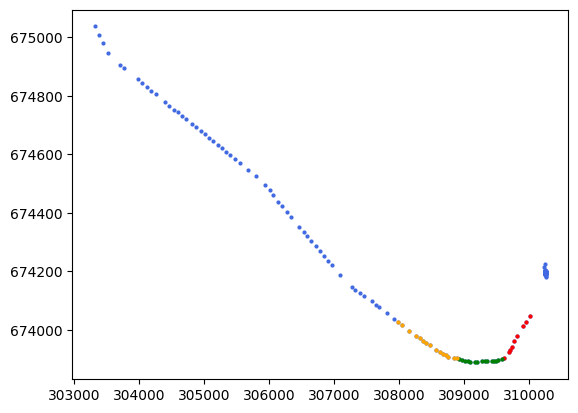

In [199]:
x = ais_dict[mmsis[2]].경도.tolist()
y = ais_dict[mmsis[2]].위도.tolist()

# temp = 140
x, y = m(x, y)
plt.plot(x, y, 'o', c='royalblue', alpha=1, markersize=2)
plt.plot(x[126:135], y[126:135], 'o', c='red', alpha=1, markersize=2)
plt.plot(x[135:150], y[135:150], 'o', c='green', alpha=1, markersize=2)
plt.plot(x[150:165], y[150:165], 'o', c='orange', alpha=1, markersize=2)
plt.show()

In [ ]:
print('Draw Basemap')
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

print('Draw Gridmap')
grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m)
        key = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon-1])
        grid_map[key] = [p, [], '']

print('Draw Ships')
for mmsi in mmsis:
    if mmsi not in current_vessel_position:
        continue
    ser = current_vessel_position[mmsi]
    mlon, mlat = m(ser['경도'], ser['위도'])
    plt.plot(mlon, mlat, 'o', c='gold', alpha=1, markersize=2)
            

print('Calculate grid congestion per each')
# 전체 기간
# for lon in ais.경도.tolist():
#     klon = find_grid_key(grid_lon, lon)
#     for lat in ais.위도.tolist():
#         klat = find_grid_key(grid_lat, lat)
#         key = '(%f,%f)'%(klat, klon)
#         grid_map[key][1] += 1

for mmsi in mmsis:
    if mmsi not in current_vessel_position:
        continue
    ser = current_vessel_position[mmsi]
    klat = find_grid_key(grid_lat, ser['위도'])
    klon = find_grid_key(grid_lon, ser['경도'])
    key = '(%f,%f)'%(klat, klon)
    grid_map[key][1].append(mmsi)

print('Draw Graduation')
xt, yt = m(np.arange(base_lon[0], base_lon[1]), np.arange(base_lat[0], base_lat[1]))
plt.xticks(xt, labels = [str(x) for x in np.arange(base_lon[0], base_lon[1])])
plt.yticks(yt, labels = [str(x) for x in np.arange(base_lat[0], base_lat[1])])

print('Draw Selected Grid')
for pos in selected_grid:
    klat = find_grid_key(grid_lat, pos[0])
    klon = find_grid_key(grid_lon, pos[1])
    key = '(%f,%f)'%(klat, klon)
    grid_map[key][2] = 'selected'
    grid_map[key][0].set(facecolor='red', alpha=0.3)
    
print('Draw Detected Grid')
detected_grid = []
temp_queue = [[find_grid_key(grid_lat, x[0]), find_grid_key(grid_lon, x[1])] for x in copy.deepcopy(selected_grid)]
temp_grid = [[find_grid_key(grid_lat, x[0]), find_grid_key(grid_lon, x[1])] for x in copy.deepcopy(selected_grid)]
while(len(temp_queue) > 0):
    pos = temp_queue.pop(0)
    grid, new_queue = find_detect_grid(grid_map, grid_lat, grid_lon, pos[0], pos[1], temp_grid)
    
    if(grid is not None):
        temp_queue = temp_queue + new_queue
        detected_grid.append(grid)
    
# grid_queue = []
# for pos in selected_grid:
#     klat = find_grid_key(grid_lat, pos[0])
#     klon = find_grid_key(grid_lon, pos[1])
#     find_detect_grid(grid_queue, grid_map, grid_lat, grid_lon, klat, klon, klat, klon)
    
plt.show()

In [30]:
grid_map.keys()

dict_keys(['(32.000000,124.000000)', '(32.043478,124.000000)', '(32.086957,124.000000)', '(32.130435,124.000000)', '(32.173913,124.000000)', '(32.217391,124.000000)', '(32.260870,124.000000)', '(32.304348,124.000000)', '(32.347826,124.000000)', '(32.391304,124.000000)', '(32.434783,124.000000)', '(32.478261,124.000000)', '(32.521739,124.000000)', '(32.565217,124.000000)', '(32.608696,124.000000)', '(32.652174,124.000000)', '(32.695652,124.000000)', '(32.739130,124.000000)', '(32.782609,124.000000)', '(32.826087,124.000000)', '(32.869565,124.000000)', '(32.913043,124.000000)', '(32.956522,124.000000)', '(33.000000,124.000000)', '(33.043478,124.000000)', '(33.086957,124.000000)', '(33.130435,124.000000)', '(33.173913,124.000000)', '(33.217391,124.000000)', '(33.260870,124.000000)', '(33.304348,124.000000)', '(33.347826,124.000000)', '(33.391304,124.000000)', '(33.434783,124.000000)', '(33.478261,124.000000)', '(33.521739,124.000000)', '(33.565217,124.000000)', '(33.608696,124.000000)', '